<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/H_Bridge_Inverter_Using_GDSTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

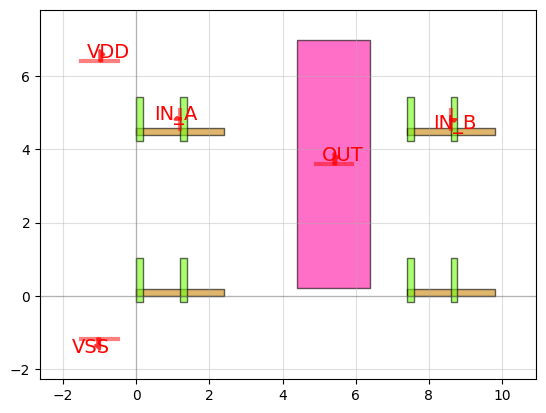

✅ Generated hbridge.gds and hbridge.svg — fetch via left sidebar or `files` module.


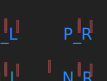

In [3]:
# @title CMOS H-Bridge Inverter Cell — Google Colab Notebook
# Colab cells are delimited by comments “# %%” for clarity.
# Author  : Onri Jay Benally
# Updated : 2025-06-03 (use `quickplot` instead of deprecated `quickplot2`)

# %% [markdown]
"""
# CMOS H‑Bridge Inverter Repeatable Cell
This Colab notebook autogenerates a **parametric CMOS H‑Bridge inverter** in
GDSII format and shows an inline preview. The workflow uses only free/open‑
source Python libraries (`phidl`, `gdstk`). Inspect or edit the final
`hbridge.gds` with **KLayout**.

Key features
------------
* **Adjustable parameters** – transistor W/L, finger count, metal width, contact size.
* **Preview** – matplotlib‑based `quickplot()` and an exported SVG snapshot.
* **Outputs** – `hbridge.gds` (layout) & `hbridge.svg` (quick view).

> Run the notebook top‑to‑bottom or hit **Runtime ▸ Run‑All**.
"""

# %% Install dependencies (≈3 s on Colab)
!pip install --quiet phidl gdstk

# %% Imports and layer map
import phidl
from phidl import Device, quickplot as qp  # <- matplotlib backend; no PyQt5 needed
import gdstk
import matplotlib.pyplot as plt

# Example GDS layer assignments (layer, datatype)
LAYER = {
    "diffusion": (65, 20),
    "poly"     : (66, 20),
    "contact"  : (67, 44),
    "metal1"   : (68, 20),
    "label"    : (10, 0),
}

# %% Primitive transistor generator

def transistor(W=1.0, L=0.15, fingers=1, name="NMOS"):
    """Create a simplistic planar transistor (layout‑agnostic)."""
    D = Device(name)

    # Active diffusion rectangle
    active = phidl.geometry.rectangle(size=(W * fingers, L), layer=LAYER["diffusion"])
    D.add_ref(active)

    # Poly gates – one stripe per finger
    for i in range(fingers):
        gate = phidl.geometry.rectangle(size=(L, W), layer=LAYER["poly"])
        gref = D.add_ref(gate)
        gref.move((i * W, -L))

    # Text label (visible in KLayout)
    D.add_label(name, position=(0, -2 * L), layer=LAYER["label"])
    return D

# %% H‑Bridge cell generator

def hbridge_cell(W=1.0, L=0.15, fingers=1, cell_name="HBRIDGE"):
    """Return a repeatable CMOS H‑Bridge inverter cell."""
    C = Device(cell_name)

    # Instantiate four transistors in H‑bridge topology
    p_left  = C.add_ref(transistor(W, L, fingers, name="P_L"))
    p_right = C.add_ref(transistor(W, L, fingers, name="P_R"))
    n_left  = C.add_ref(transistor(W, L, fingers, name="N_L"))
    n_right = C.add_ref(transistor(W, L, fingers, name="N_R"))

    # Placement (simple grid — tweak as desired)
    p_left.move((0, 2 * W + 2))
    p_right.move((W * fingers + 5, 2 * W + 2))
    n_left.move((0, 0))
    n_right.move((W * fingers + 5, 0))

    # Central metal connection (OUT node)
    mid = phidl.geometry.rectangle(size=(2, 4 * W + 2), layer=LAYER["metal1"])
    mid_ref = C.add_ref(mid)
    mid_ref.move((W * fingers + 2, W - 1))

    # Define ports for routing / tiling (no `layer` kwarg in Phidl ≥1.6.0)
    C.add_port("IN_A", midpoint=p_left.center,  width=0.5, orientation=180)
    C.add_port("IN_B", midpoint=p_right.center, width=0.5, orientation=0)
    C.add_port("VDD",  midpoint=(p_left.xmin - 1, p_left.ymax + 1), width=1.0, orientation=90)
    C.add_port("VSS",  midpoint=(n_left.xmin - 1, n_left.ymin - 1), width=1.0, orientation=-90)
    C.add_port("OUT",  midpoint=mid_ref.center,                        width=1.0, orientation=90)

    return C

# %% Generate and preview the cell (matplotlib view)
cell = hbridge_cell(W=1.2, L=0.18, fingers=2, cell_name="HBRIDGE_X1")
qp(cell)  # interactive plot (matplotlib) — works on Colab
plt.show()

# %% Export GDS + SVG previews
cell.write_gds("hbridge.gds")
cell.write_svg("hbridge.svg")
print("✅ Generated hbridge.gds and hbridge.svg — fetch via left sidebar or `files` module.")

# Display SVG inline for a quick sanity check
from IPython.display import SVG
SVG("hbridge.svg")
